In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

import import_ipynb
from plastic_nn import plastic_nn
from plastic_nn import input_layer
from plastic_nn import layer

importing Jupyter notebook from plastic_nn.ipynb


In [2]:

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)




class MountainCarDQL():
    # Hyperparameters (adjustable)
    
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    num_divisions = 20

    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        plt.figure(1)
        plt.subplot(121) 
        plt.plot(rewards_per_episode)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        plt.savefig('mountaincar_dql.png')

    

    def train(self, policy_dqn, target_dqn, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        goal_reached = False
        best_rewards = -200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards>-1000):
                if random.random() < epsilon:
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    res = policy_dqn.forward(self.state_to_dqn_input(state))
                    #print(res)
                    action = res.argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count+=1


            rewards_per_episode.append(rewards)
            epsilon_history.append(epsilon)
            
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')

                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                #torch.save(policy_dqn.state_dict(), f"mountaincar_dql_{i}.pt")

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                #print(f'Episode {i} Epsilon {epsilon} rewards {rewards}') # print(rewards)
                mini_batch = memory.sample(self.mini_batch_size) #len(memory))#
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon*0.9999, 0.05)#epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    # print("BEFORE COPY")
                    # policy_dqn.print_info()
                    # target_dqn.print_info()
                    
                    target_dqn = policy_dqn.deep_copy()
                    
                    # print("AFTER COPY")
                    # policy_dqn.print_info()
                    # target_dqn.print_info()
                    
                    step_count = 0

        env.close()



    
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []
        #print('before! ')
        #self.test(policy_dqn, 1)
        
        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                target = reward
            else:
                target = reward + self.discount_factor_g * target_dqn.forward(self.state_to_dqn_input(new_state)).max()


            # Get the target set of Q values
            target_q = target_dqn.forward_nu(self.state_to_dqn_input(state))
            
            # Get the current set of Q values
            current_q = policy_dqn.forward(self.state_to_dqn_input(state))
            current_q_list.append(current_q)
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

    
            #BACKPOP AND UPDATE
            #err =  target_q - current_q
            #policy_dqn.backprop_error(err)
            #print('backprop\n')
            policy_dqn.backprop(target_q)
            policy_dqn.update_w()

            #print('\nupdate! ')
            #self.test(policy_dqn, 1)
        
        # Compute loss for the whole minibatch ??
    
        #loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        #self.optimizer.zero_grad()
        #loss.backward()
        #self.optimizer.step()


    def state_to_dqn_input(self, state)->torch.Tensor:
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)

        return torch.FloatTensor([state_p, state_v])

    # Run the environment with the learned policy
    def test(self, policy_dqn, episodes):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        # Load learned policy
        #policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        #policy_dqn.load_state_dict(torch.load(model_filepath))
        #policy_dqn.eval()    # switch model to evaluation mode
        flag = False
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                dscr = self.state_to_dqn_input(state)
                res = policy_dqn.forward_print(dscr)
                if (not flag):
                    print(dscr, '\n', res)
                    flag = True
                action = res.argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)
                #terminated = True

        env.close()


In [3]:
learning_rate_a = 0.01
in_states = 2
h1_nodes = 10
out_actions = 3

layers_net = [input_layer(in_states), 
layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type="ReLU"), 
layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=out_actions, activation_type='Linear')] #, activation_type="ReLU")]

policy_dqn = plastic_nn()
policy_dqn.append(layers_net)

target_dqn = plastic_nn()
target_dqn = policy_dqn.deep_copy()
        
# env = gym.make('MountainCar-v0') #, render_mode='human' if render else None)
# state, _ = env.reset()

# pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
# vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07
# state_p = np.digitize(state[0], pos_space)
# state_v = np.digitize(state[1], vel_space)
# state=[state_p, state_v]

# print(policy_dqn.forward(state))
# env.close()

added LAYERS succesfully


In [4]:
mountaincar = MountainCarDQL()

Episode 1000 Epsilon 0.9455364882080144
Episode 2000 Epsilon 0.8555525165904533


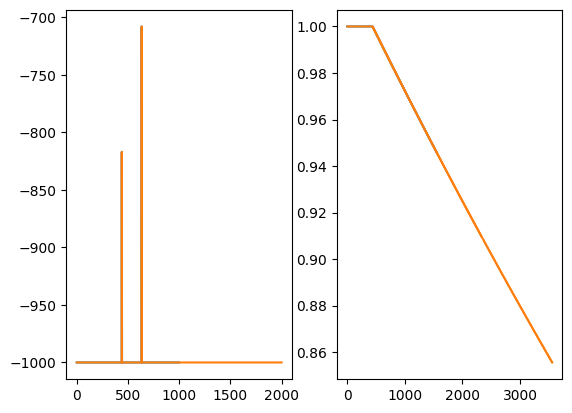

In [8]:
mountaincar.train(policy_dqn, target_dqn, 3000, False)

In [9]:
mountaincar.test(policy_dqn, 1)

in:  tensor([ 8., 10.])
0   tensor([ 8., 10.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
tensor([ 8., 10.]) 
 [0. 0. 0.]
in:  tensor([ 8., 10.])
0   tensor([ 8., 10.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([ 8., 10.])
0   tensor([ 8., 10.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([ 8., 10.])
0   tensor([ 8., 10.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([8., 9.])
0   tensor([8., 9.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([8., 9.])
0   tensor([8., 9.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([8., 9.])
0   tensor([8., 9.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([8., 9.])
0   tensor([8., 9.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([7., 9.])
0   tensor([7., 9.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor([7., 9.])
0   tensor([7., 9.])
1   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 0.]
in:  tensor(

In [9]:
policy_dqn.print_info()

NAME:  noname  ( 3 )
# 0
IN LAYER
size:  2
[0. 0.]

# 1
my size:  10
w:  [[-23.89827477 -17.77092785 -29.40379132 -29.16439421 -15.78084155
  -30.60753158 -15.88017316 -23.42161758  -0.03200742 -27.09514328]
 [-21.6321314  -15.3489488  -26.46377907 -25.70781421 -14.34704225
  -26.57480327 -13.49419482 -21.13400796  -0.13673212 -23.72704454]] 


# 2
my size:  3
w:  [[-0.87727068 -1.10609488 -0.99984563]
 [-1.05241044 -0.9594009  -1.36929465]
 [-1.26598619 -0.33403382 -0.88209812]
 [-0.79505306 -0.73594365 -0.98540722]
 [-1.01070056 -1.04921081 -1.45237084]
 [-0.61292209 -0.2293112  -1.4333003 ]
 [-1.41927083 -0.9801436  -1.19520276]
 [-0.7286101  -1.11726064 -1.16734538]
 [ 0.97412528  0.46262836  0.80678543]
 [-0.94719458 -0.66556285 -1.04709263]] 


